In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def exp_plat(ym, k, x):
    return ym * (1 - np.exp(-k * x))

EIR = np.linspace(1, 100, dtype=np.float32)
k = 5 * 1e-2
ym = .7
prev = exp_plat(ym, k, EIR)

In [3]:
sample_size = 50
EIR_sample = np.random.randint(1,100,sample_size).astype(np.float32)

In [4]:
sigma = 0.05
def bounded(x, l, u):
    return np.minimum(np.maximum(x, l), u)

prev_sample = bounded(exp_plat(ym, k, EIR_sample) + np.random.normal(size=len(EIR_sample), scale=sigma), 0, 1).astype(np.float32)
pop_sample = np.maximum(np.random.normal(size=len(EIR_sample), loc=10000, scale=1000), 0.).astype(np.float32)

Text(0, 0.5, 'prev')

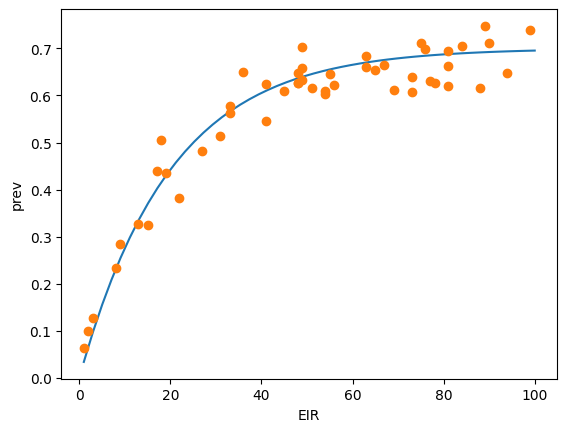

In [5]:
plt.plot(EIR, prev)
plt.plot(EIR_sample, prev_sample, 'o')
plt.xlabel('EIR')
plt.ylabel('prev')

In [6]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf

2022-11-30 13:23:42.102122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 13:23:42.622454: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import matplotlib.pyplot as plt

In [8]:
model = load_model('./models/eq/')

2022-11-30 13:23:51.016992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 13:23:53.019829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-11-30 13:23:53.038767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [9]:
default_params = pd.read_csv('default_params.csv')
bounds = pd.read_csv('./outputs/eq/bounds.csv',dtype={'name': str, 'min': np.float32, 'max': np.float32})
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
default_dict = dict(default_params.itertuples(index=False))

In [10]:
clipper = tfp.bijectors.SoftClip(bounds['min'], bounds['max'], hinge_softness=1e-10)
pop_sample_tf = tf.constant(pop_sample)

@tf.function
def model_prev(kb, ub, b0, b1, IB0, eir):
    param_shape = kb.shape
    X_ = tf.stack([
        tf.fill(param_shape, default_dict['eta']), # default age
        tf.fill(param_shape, default_dict['Q0']),
        tf.fill(param_shape, default_dict['s2']),
        tf.fill(param_shape, default_dict['rU']),
        tf.fill(param_shape, default_dict['cD']),
        tf.fill(param_shape, default_dict['g_inf']),
        tf.fill(param_shape, default_dict['cU']),
        kb,
        ub,
        tf.fill(param_shape, default_dict['uc']),
        tf.fill(param_shape, default_dict['ud']),
        tf.fill(param_shape, default_dict['kc']),
        b0,
        b1,
        IB0,
        tf.fill(param_shape, default_dict['IC0']),
        tf.fill(param_shape, default_dict['tau']),
        tf.fill(param_shape, default_dict['phi0']),
        tf.fill(param_shape, default_dict['phi1']),
        tf.fill(param_shape, default_dict['mu']),
        tf.fill(param_shape, default_dict['f']),
        tf.fill(param_shape, default_dict['fd0']),
        tf.fill(param_shape, default_dict['ad0']),
        tf.fill(param_shape, default_dict['gd'])
    ], axis=len(param_shape))
    if len(X_.shape) == 1:
        X_ = tf.expand_dims(X_, axis=0)
        eir = tf.expand_dims(eir, axis=0)
    batch_size = X_.shape[0]
    sites = eir.shape[1]
    X_ = tf.repeat(X_, sites, axis=0)
    eir_rep = tf.reshape(eir, (batch_size * sites, 1))
    X = tf.concat([eir_rep, X_], axis=1)
    prev_pred = model(clipper(X))
    return tf.reshape(prev_pred, (batch_size, sites))

@tf.function
def prob_prev(kb, ub, b0, b1, IB0, eir):
    prev_pred = model_prev(kb, ub, b0, b1, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1,
        name='prev'
    )

In [87]:
from collections import OrderedDict
EIR_sigma = 1
EIR_guesses = bounded(EIR_sample + np.random.normal(size=len(EIR_sample), scale=EIR_sigma).astype(np.float32), 1., 100.)
    
joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(1., 7., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev(kb, ub, b0, b1, IB0, EIR)
    )
)

In [88]:
*prior_samples, prior_predictive = joint_dist.sample(1000).values()

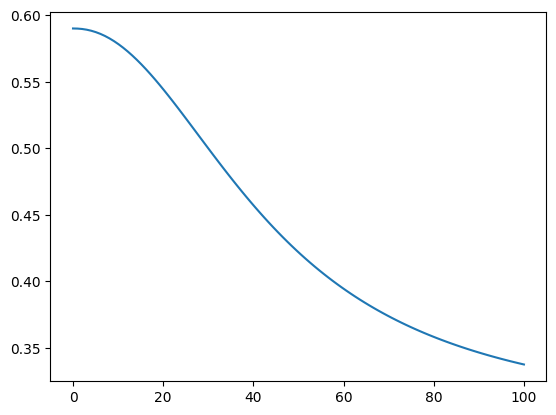

In [36]:
IB = np.linspace(0, 100, num=100)
b0, b1, IB0, kb = default_dict['b0'], default_dict['b1'], default_dict['IB0'], default_dict['kb']
b = b0*(b1 + (1-b1)/(1+(IB/IB0)**kb))
plt.plot(IB, b)

(array([ 5.,  2.,  5.,  7.,  6.,  8.,  9.,  9.,  9., 14., 12., 21., 13.,
        26., 30., 20., 26., 29., 27., 29., 31., 25., 33., 19., 27., 36.,
        30., 24., 25., 17., 23., 24., 22., 23., 33., 17., 22., 22., 21.,
        13., 17., 15., 11., 10., 16.,  8., 18.,  9.,  5.,  5.,  2.,  8.,
        11.,  7.,  5.,  3.,  5.,  3.,  7.,  3.,  8.,  3.,  3.,  2.,  3.,
         3.,  0.,  2.,  1.,  2.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  7.89244604,   9.37010956,  10.8477726 ,  12.32543659,
         13.80309963,  15.28076267,  16.75842667,  18.23608971,
         19.71375275,  21.19141579,  22.66907883,  24.14674377,
         25.62440681,  27.10206985,  28.57973289,  30.05739594,
         31.53506088,  33.01272202,  34.49038696,  35.96805191,
         37.44571304,  38.92337799,  40.40103912,  41.87870407,
         43.3563652 ,  44.83403015,  46.3116951 , 

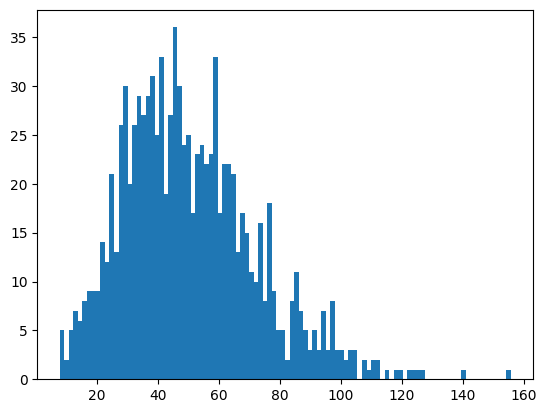

In [130]:
plt.hist(prior_samples[4], bins=100)

In [89]:
b0, b1, IB0, kb = prior_samples[2], prior_samples[3], prior_samples[4], prior_samples[0]
b = b0*(b1 + (1-b1)/(1+(IB[:, np.newaxis]/IB0)**kb))

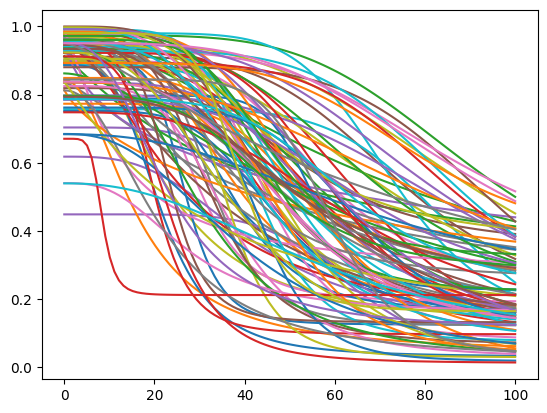

In [93]:
plt.plot(IB, b[:, :100])

In [94]:
import arviz as az

In [95]:
prior_trace = az.from_dict(
    observed_data={"observations": pop_sample * prev_sample},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(sample_size)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 1000, observation: 50)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observation   (observation) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    observations  (chain, draw, observation) float32 6.666e+03 ... 5.913e+03
Attributes:
    created_at:     2022-11-30T14:09:54.330035
    arviz_version:  0.13.0


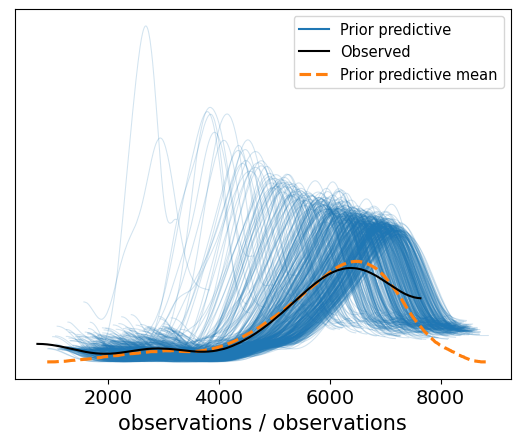

In [96]:
ax = az.plot_ppc(prior_trace, group="prior", num_pp_samples=500)

In [97]:
#raise Error()
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(prior_keys):
            ax = axes[r][c]
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

NameError: name 'prior' is not defined

In [100]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

observed_prev = tf.constant(pop_sample * prev_sample)
pinned_joint_dist = joint_dist.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob(*state):
    return pinned_joint_dist.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

CPU times: user 41min 52s, sys: 49.9 s, total: 42min 42s
Wall time: 1h 4min 57s


In [101]:
acceptance.numpy().mean()

0.924

In [102]:
parameter_names = pinned_joint_dist._flat_resolve_names()

In [103]:
posterior_predictive = tf.concat([list(joint_dist.sample(value=dict(zip(parameter_names, [s[:,chain,...] for s in samples]))).values())[-1][tf.newaxis, ...] for chain in range(num_chains)], 0)

In [104]:
trace = az.from_dict(
    prior={k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, samples)
    },
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    posterior_predictive={"observations": posterior_predictive},
    coords={"observation": np.arange(sample_size), "param": np.arange(len(parameter_names))},
    observed_data={"observations": pop_sample * prev_sample},
    dims={"observations": ["observation"], "coefficients": ["param"]},
)

print(trace)

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data


In [105]:
print(az.summary(trace).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_mean", "r_hat"]))

           mean  hdi_3%  hdi_97%  r_hat
kb        1.093   0.013    3.260   3.57
ub       16.619   9.840   27.728   1.38
b0        0.451   0.359    0.925   3.11
b1        0.720   0.000    0.929   3.54
IB0      41.058  20.899   57.618   6.17
EIR[0]   27.571  25.972   29.111   1.16
EIR[1]   54.372  51.641   57.004   1.24
EIR[2]   48.689  47.151   50.137   1.07
EIR[3]   12.921   8.009   14.326   1.61
EIR[4]    1.183   0.997    1.352   1.25
EIR[5]   67.060  65.273   68.851   1.02
EIR[6]   49.811  48.216   51.653   1.21
EIR[7]   34.215  32.467   36.063   1.33
EIR[8]    8.937   4.903   10.067   1.62
EIR[9]   78.270  76.459   80.030   1.03
EIR[10]   0.034   0.006    0.076   2.08
EIR[11]  86.323  84.362   88.206   1.04
EIR[12]  98.640  97.617   99.798   1.90
EIR[13]  22.090  19.222   23.748   1.47
EIR[14]  16.279  11.766   17.726   1.52
EIR[15]  80.840  79.102   82.530   1.01
EIR[16]  80.240  78.162   81.845   1.00
EIR[17]  46.157  44.793   47.620   1.10
EIR[18]  65.628  63.947   67.405   1.01


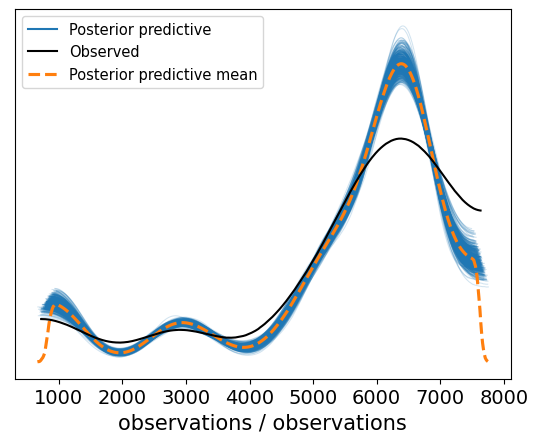

In [106]:
ax = az.plot_ppc(trace, group="posterior", num_pp_samples=500)

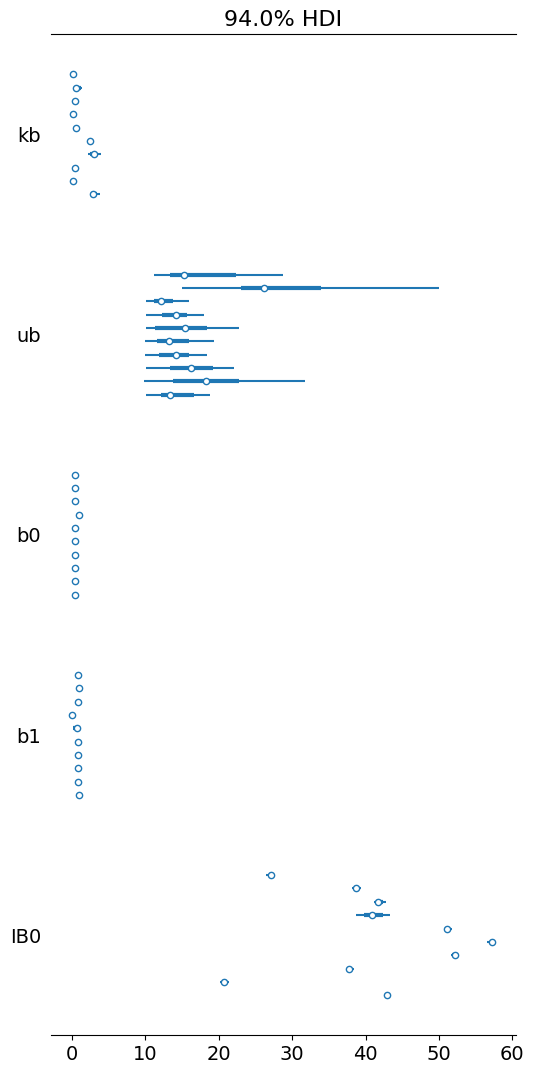

In [107]:
axs = az.plot_forest(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

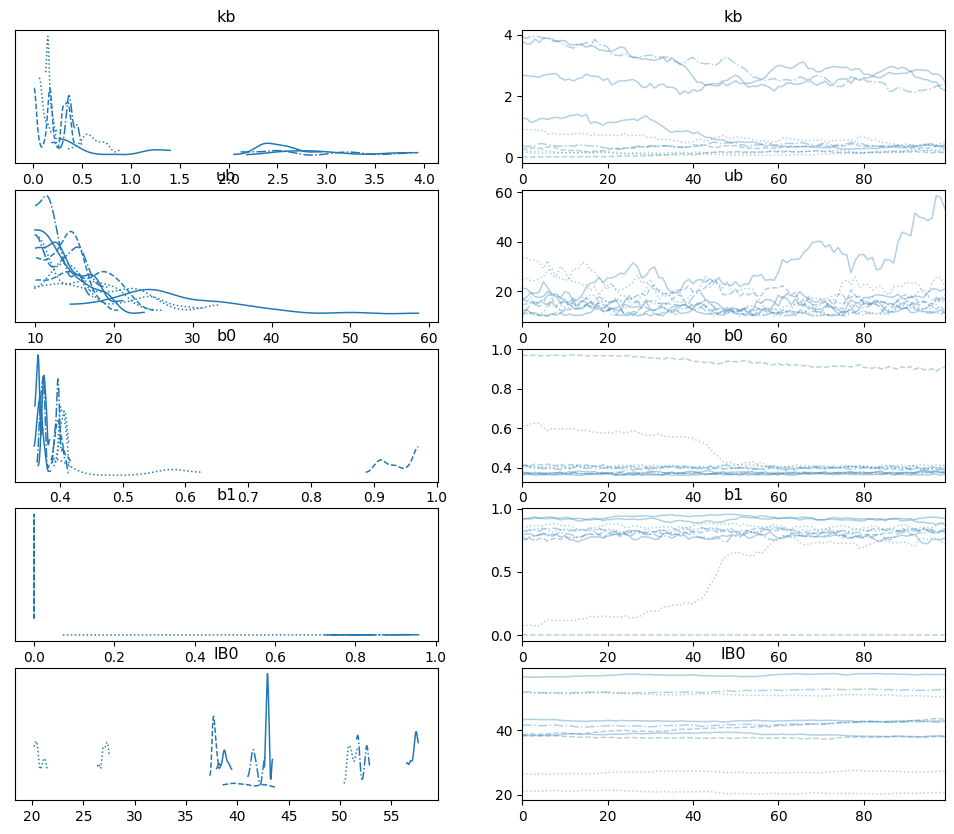

In [108]:
axs = az.plot_trace(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

In [383]:
posterior = dict(zip(initial_state_dict.keys(), samples))

<Figure size 640x480 with 0 Axes>

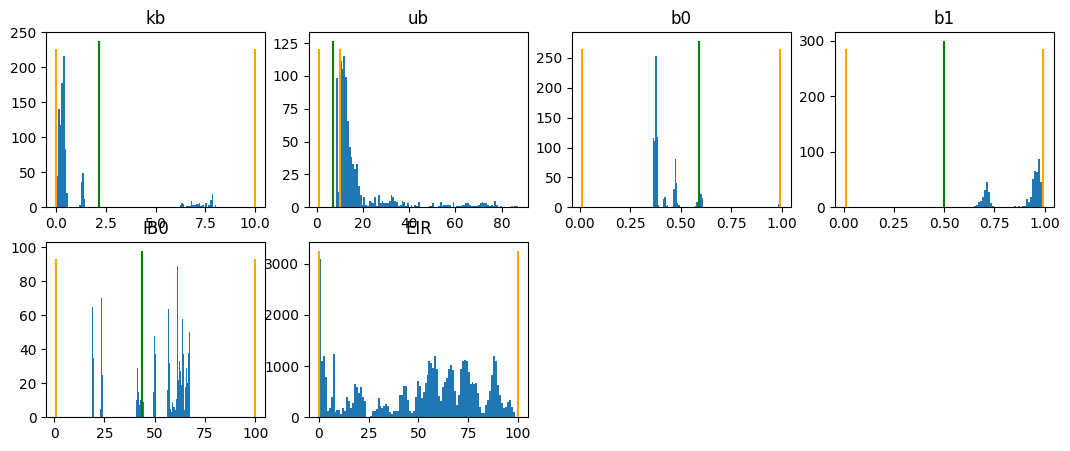

In [384]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(posterior_keys):
            ax = axes[r][c]
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

<Figure size 640x480 with 0 Axes>

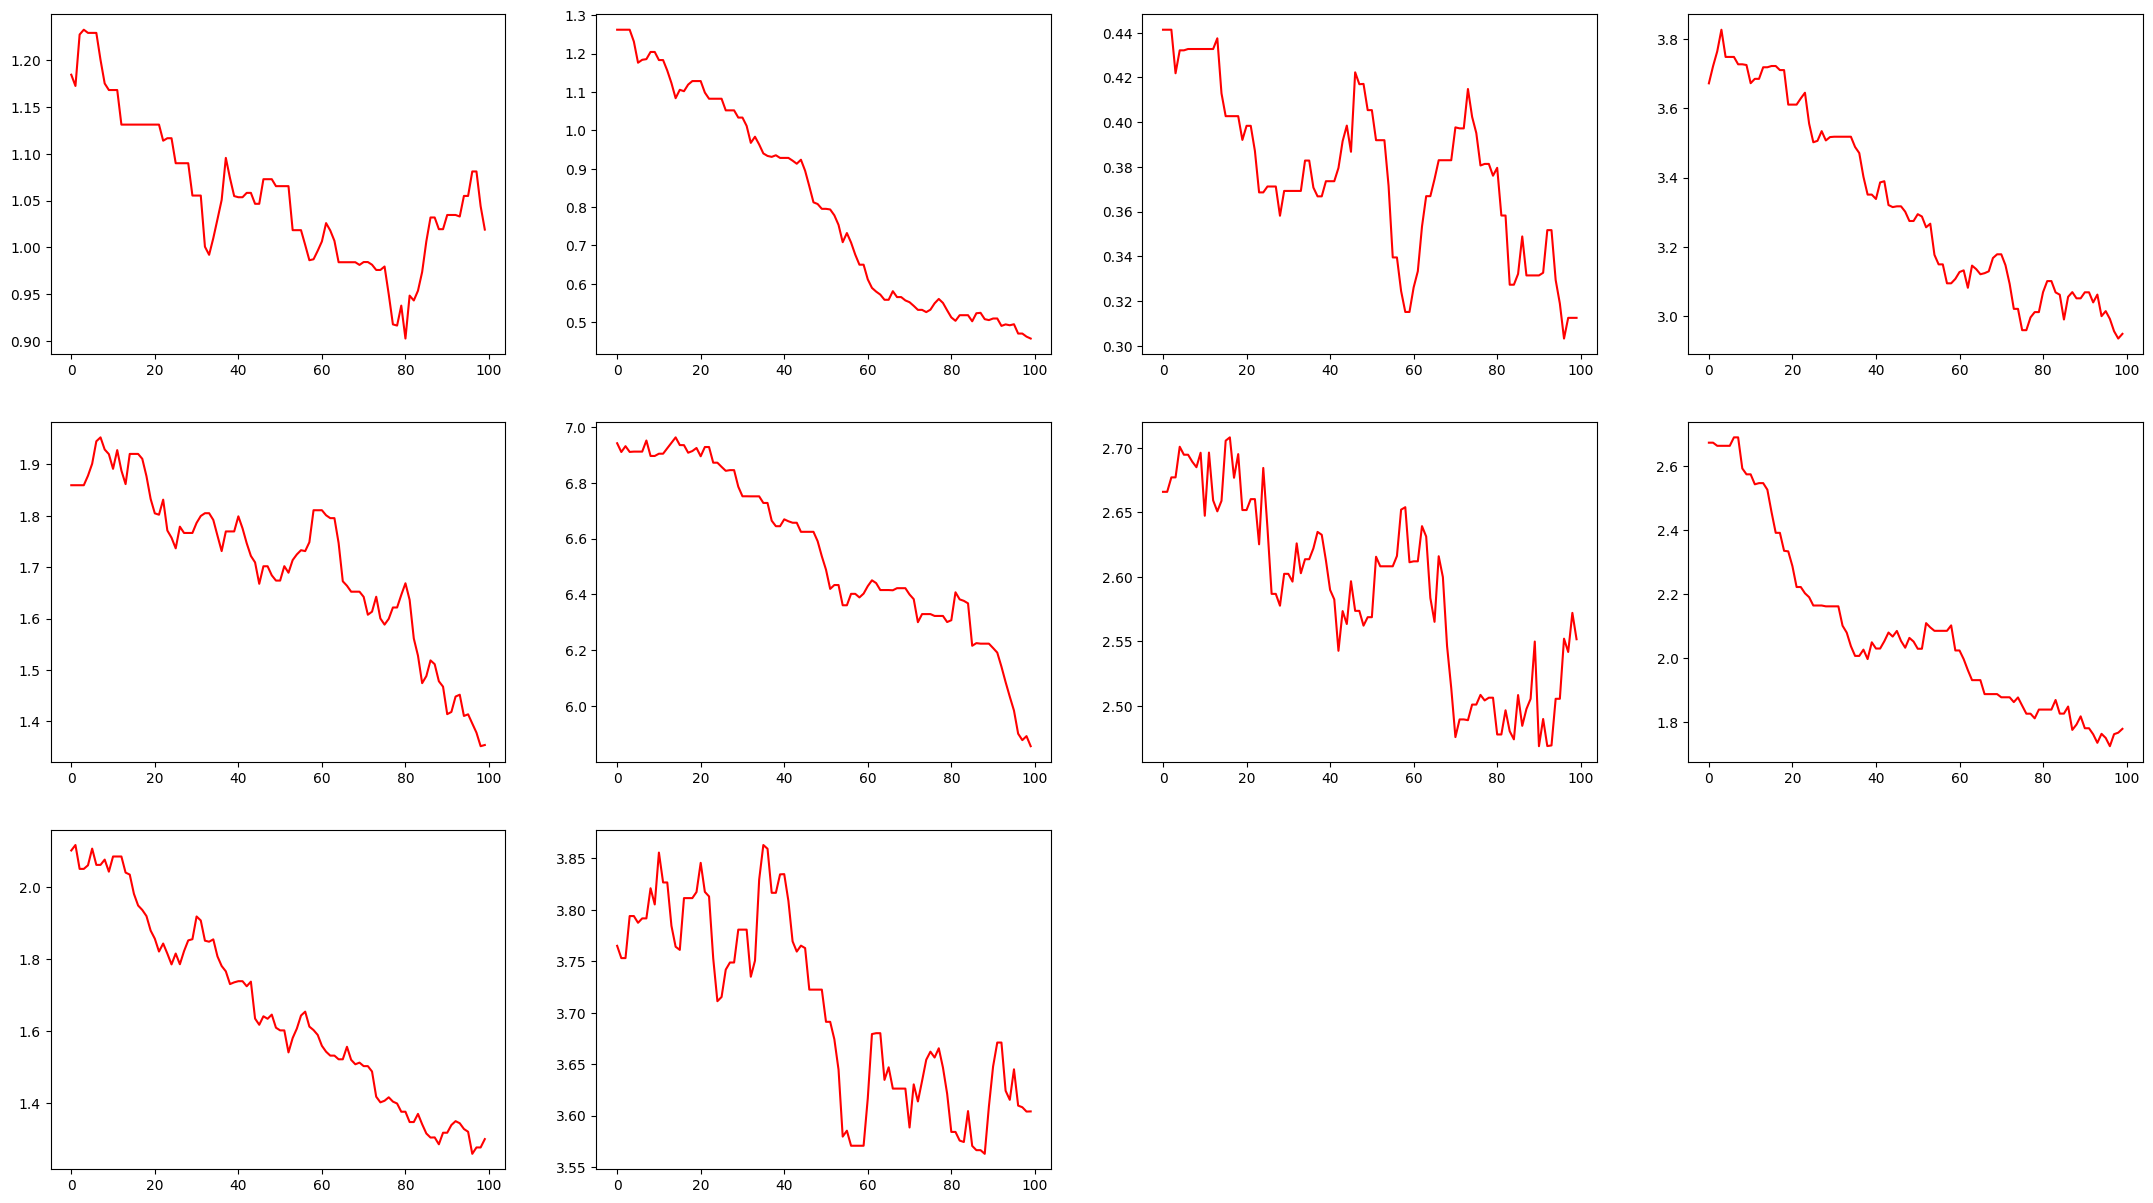

In [279]:
variable = 0
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            ax.plot(samples[variable][:, i:i + 1], color='red')
        else:
            fig.delaxes(ax)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([2.11755681e+00, 6.97280945e+02, 1.39244434e+03, 2.08760767e+03,
        2.78277100e+03, 3.47793433e+03, 4.17309766e+03, 4.86826123e+03,
        5.56342432e+03, 6.25858789e+03, 6.95375098e+03, 7.64891455e+03,
        8.34407812e+03, 9.03924121e+03, 9.73440430e+03, 1.04295684e+

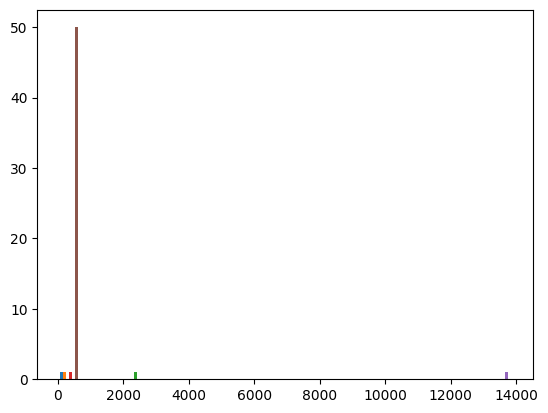

In [335]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=20)

In [336]:
tfp.mcmc.potential_scale_reduction(samples)

[<tf.Tensor: shape=(), dtype=float32, numpy=83.5312>,
 <tf.Tensor: shape=(), dtype=float32, numpy=16.933573>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2149.009>,
 <tf.Tensor: shape=(), dtype=float32, numpy=236.48454>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13905.385>,
 <tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([ 10.710046 ,  15.777975 ,  12.692931 ,   2.966445 , 111.75598  ,
         10.960857 ,   9.763073 ,   4.2560735,   7.860901 ,  15.09038  ,
          6.2519517,  12.706726 ,   4.1204348, 112.99267  ,  51.48278  ,
         16.915834 ,   3.9415274,   4.0826163,   4.1029987,   8.318531 ,
        109.99985  ,  12.461017 ,  22.761599 ,   8.776797 ,  58.258682 ,
          4.877744 ,   3.8683379, 221.3657   ,   3.073891 ,   8.402253 ,
          5.353343 ,   9.006002 ,  44.351032 ,  45.44587  ,   2.1175568,
          5.3978505,  24.55932  ,  67.283035 ,   4.535808 ,  51.025608 ,
          2.750064 ,   3.4755945,   3.5778227,   4.752894 ,   4.754856 ,
          8.120264

In [110]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import copy
eq = importr('malariaEquilibrium')
r_default_params = eq.load_parameter_set()
ages = ro.FloatVector(range(100))

In [111]:
def single_prev(params, eir):
    states = eq.human_equilibrium(eir, ft = 0., p=params, age=ages)
    return sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'pos_M')) / sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'prop'))

def model_prev_r(kb, ub, b0, b1, IB0, eir):
    params = [kb, ub, b0, b1, IB0, eir]
    if len(kb.shape) == 0:
        return 0
        params = [tf.expand_dims(p, axis=0) for p in params]
        eir = tf.expand_dims(eir, axis=0)
    batch_size = params[0].shape[0]
    sites = eir.shape[1]
    prev = np.zeros((batch_size, sites), dtype=np.float32)
    for b in range(batch_size):
        for n, p in zip(['kb', 'ub', 'b0', 'b1', 'IB0'], params):
            batch_params = copy.deepcopy(r_default_params)
            batch_params.rx2[n] = ro.FloatVector([p[b].numpy()])
        for e_i, e in enumerate(eir[b, :]):
            prev[b, e_i] = single_prev(batch_params, ro.FloatVector([e.numpy()]))
    return prev

def prob_prev_r(kb, ub, b0, b1, IB0, eir):
    prev_pred = model_prev_r(kb, ub, b0, b1, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1
    )

In [123]:
kb = tfd.Gamma(4., 1., validate_args=True).sample(10)
ub = tfd.LogNormal(1., 1., validate_args=True).sample(10)
b0 = tfd.Beta(7., 1., validate_args=True).sample(10)
b1 = tfd.Beta(1., 7., validate_args=True).sample(10)
IB0 = tfd.Gamma(5., .1, validate_args=True).sample(10)
EIR = tfd.Independent(tfd.TruncatedNormal(loc=[32., 5.], scale=np.full(2, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1).sample(10) #?? are we varying EIR too much??

In [121]:
EIR[]

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[32.937107,  3.655722]], dtype=float32)>

In [126]:
p = model_prev_r(kb, ub, b0, b1, IB0, EIR)

In [127]:
p

array([[0.6265913 , 0.35092732],
       [0.6209166 , 0.36413383],
       [0.6318492 , 0.34653476],
       [0.6355712 , 0.32927173],
       [0.6185637 , 0.3101539 ],
       [0.6376969 , 0.34565228],
       [0.6062783 , 0.35980585],
       [0.61634964, 0.28187475],
       [0.64097154, 0.34203663],
       [0.6351584 , 0.31739306]], dtype=float32)

In [129]:
ub

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([3.9885693, 0.56639  , 3.64555  , 2.579014 , 1.7573133, 1.7537117,
       1.123868 , 2.9130712, 0.8327465, 4.418352 ], dtype=float32)>

In [391]:
joint_dist_r = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(1., 7., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev_r(kb, ub, b0, b1, IB0, EIR)
    )
)

In [394]:
*prior_samples, prior_predictive = joint_dist_r.sample(1000).values()

In [395]:
prior_trace_r = az.from_dict(
    observed_data={"observations": pop_sample * prev_sample},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(sample_size)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 1000, observation: 50)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observation   (observation) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    observations  (chain, draw, observation) float32 7.422e+03 ... 6.853e+03
Attributes:
    created_at:     2022-11-01T16:39:47.502374
    arviz_version:  0.13.0


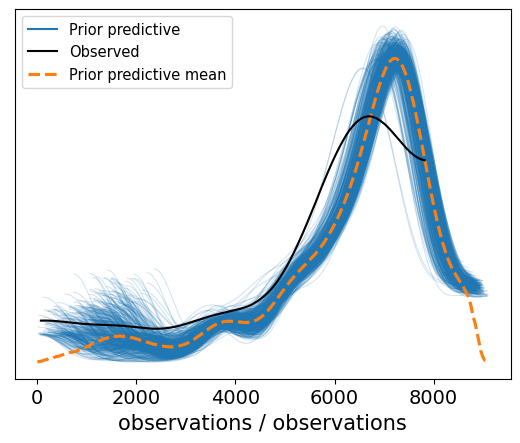

In [396]:
ax = az.plot_ppc(prior_trace_r, group="prior", num_pp_samples=500)

In [ ]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

pinned_joint_dist_r = joint_dist_r.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist_r.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob_r(*state):
    return pinned_joint_dist_r.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob_r,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist_r.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

In [ ]:
samples